# ECE685D Homework5

## Problem 1: GAN

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class TransConvNormActi(nn.Module):
    """Basic block consists of a transposed convolutional layer, a normalization layer and an activation."""
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, **kwargs):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                             kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.acti = nn.ReLU()

    def forward(self, x):
        return self.acti(self.bn(self.trans_conv(x)))


class ConvNormActi(nn.Module):
    """Basic block consists of a convolutional layer, a normalization layer and an activation."""
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.acti = nn.ReLU()

    def forward(self, x):
        return self.acti(self.bn(self.conv(x)))


class Generator(torch.nn.Module):
    def __init__(self):

        super(Generator, self).__init__()

        self.net = nn.Sequential(
            TransConvNormActi(100, 256, kernel_size=7, stride=1, padding=0),
            TransConvNormActi(256, 128, kernel_size=4, stride=2, padding=1),
            TransConvNormActi(128, 64, kernel_size=4, stride=2, padding=1),
            ConvNormActi(64, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()

        )

    def forward(self, x):
        """The forward function should return batch of images."""
        return self.net(x)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            ConvNormActi(1, 64, kernel_size=3, stride=2, padding=1),
            ConvNormActi(64, 128, kernel_size=3, stride=2, padding=1),
            ConvNormActi(128, 256, kernel_size=3, stride=2, padding=1),
            ConvNormActi(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=4, padding=0),
            nn.Flatten()
        )

    def forward(self, x):
        """The forward function should return the logits."""
        return self.net(x)


class DCGAN(nn.Module):
    def __init__(self, epochs, batch_size, device='cpu'):
        super(DCGAN, self).__init__()
        ##### ---- YOUR CODE HERE ---- #####
        self.G = Generator()
        self.D = Discriminator()
        self.loss = nn.BCEWithLogitsLoss()
        ##### ----                ---- #####

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        self.number_of_images = 10

        self.to(device)

    def train_loop(self, train_loader):

        disc_loss = []
        genr_loss = []

        generator_iter = 0

        for epoch in range(self.epochs):
            d_loss_all, g_loss_all, num_all = 0., 0., 0
            loader_tqdm = tqdm(train_loader, ncols=80)
            for i, (images, _) in enumerate(loader_tqdm):

                # Step 1: Train discriminator
                current_batch_size = images.shape[0]
                z = torch.randn((current_batch_size, 100, 1, 1), device=self.device)

                real_labels = torch.ones(current_batch_size, device=self.device)
                fake_labels = torch.zeros(current_batch_size, device=self.device)

                images = images.to(self.device)

                # Compute the BCE Loss using real images
                real_logits = self.D(images)
                real_logits = torch.squeeze(real_logits)
                d_loss_real = self.loss(real_logits, real_labels)

                # Compute the BCE Loss using fake images
                fake_images = self.G(z)
                fake_logits = self.D(fake_images)
                fake_logits = torch.squeeze(fake_logits)
                d_loss_fake = self.loss(fake_logits, fake_labels)

                # Optimize discriminator
                d_loss = d_loss_real + d_loss_fake
                self.D.zero_grad()
                d_loss.backward()
                self.d_optimizer.step()

                # Step 2: Train Generator
                z = torch.randn((current_batch_size, 100, 1, 1), device=self.device)

                fake_images = self.G(z)
                fake_logits = self.D(fake_images)
                fake_logits = torch.squeeze(fake_logits)
                g_loss = self.loss(fake_logits, real_labels)

                self.D.zero_grad()
                self.G.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()
                generator_iter += 1

                loader_tqdm.set_description('Ep %d' % epoch)

                d_loss_all += d_loss.item() * current_batch_size
                g_loss_all += g_loss.item() * current_batch_size
                num_all += current_batch_size

            disc_loss.append(d_loss_all / num_all)
            genr_loss.append(g_loss_all / num_all)

            loader_tqdm.close()

        return disc_loss, genr_loss

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            generated_images.append(sample.reshape(28, 28))
        return generated_images

In [ ]:
epochs = 20
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./Data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./Data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

In [ ]:
model = DCGAN(epochs = epochs, batch_size=batch_size, device=device)
disc_loss, genr_loss = model.train_loop(train_loader=train_loader)

Ep 19: 100%|██████████████████████████████████| 938/938 [00:31<00:00, 29.73it/s]


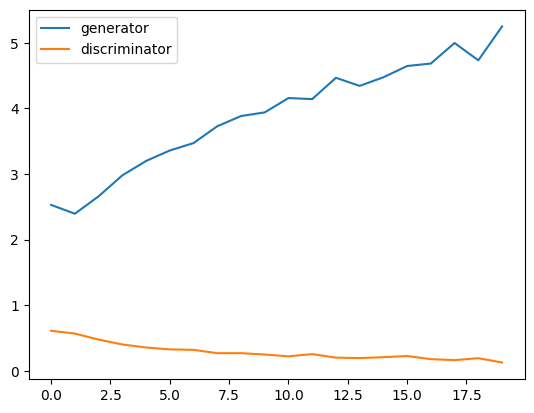

In [ ]:
plt.figure()
plt.plot(list(range(len(genr_loss))), genr_loss, label='generator')
plt.plot(list(range(len(disc_loss))), disc_loss, label='discriminator')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
z = torch.randn((20, 100, 1, 1), device=device)
model.eval()
image_generated = model.generate_img(z, 20)
image_for_visual = torch.cat([torch.cat([torch.tensor(image_generated[i]) for i in range(10*j, 10*j+10)], dim=1) for j in range(2)], dim=0)

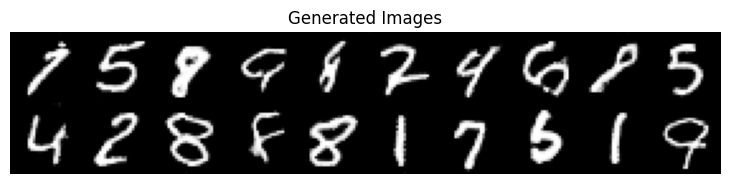

In [ ]:
plt.figure(figsize=(10, 2))
plt.gray()
plt.imshow(image_for_visual.numpy())
plt.tight_layout()
plt.axis('off')
plt.title('Generated Images')
plt.show()

## Problem 2: LSTM

In [ ]:
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
import numpy as np
from tqdm import trange
from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#download corpus
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/zihaochen/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zihaochen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# prepare dataset
corpus = nltk.corpus.gutenberg.raw('austen-sense.txt')

#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove \n
    text = re.sub('\n', ' ', text)
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    #remove extra spaces
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

corpus = denoise_text(corpus)
words = corpus.split(' ')
unique_words = np.unique(words)
vocab_size = len(unique_words)

In [ ]:
# create the mapping function between word and index
word_to_idx = {word: idx for idx, word in enumerate(unique_words)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [ ]:
# convert the words to indexes
indexes = [word_to_idx[word] for word in words]
X = np.array([indexes[i:i+5] for i in range(len(indexes) - 5)])
y = np.array([indexes[i+1:i+6] for i in range(len(indexes) - 5)])

# Convert your dataset to tensors
train_data = TensorDataset(torch.from_numpy(X.astype('int')), torch.from_numpy(y.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input features: \n', sample_x)
print('Sample input labels: \n', sample_y)

Sample input size:  torch.Size([50, 5])
Sample input features: 
 tensor([[ 744, 3231, 6289, 5251, 3735],
        [6371, 2712, 4382, 2729, 5678],
        [4411, 3917, 2348, 2764,  319],
        [5107, 6173, 3769, 1872, 4931],
        [ 319, 5973, 6289,   52, 2733],
        [3717, 5256, 5664, 6289, 2791],
        [1217, 5678, 4087, 2883, 4962],
        [ 416, 6173, 4710, 6222, 2791],
        [6211,  749, 4693, 5618, 2362],
        [2791, 5863, 5722, 4279,  319],
        [3526, 6247, 6184, 2712,  263],
        [2968, 2056, 4798, 5107, 6173],
        [5678, 4380, 3917, 2599, 5678],
        [ 243, 5670, 2764, 3718, 3946],
        [1901,  281,  125,  319, 3859],
        [5251, 3051,  435, 3734,  764],
        [5752, 5678, 1767,  319, 5685],
        [6184, 5135,  583, 6095, 2539],
        [2883, 6211, 6371, 2883, 6339],
        [ 607, 4188, 3011, 3495, 2765],
        [2362,  787, 2764, 5200,  545],
        [3960, 5752, 5678, 4201,  319],
        [5752, 2553, 6095, 6208, 2968],
        [3917, 

In [ ]:
class LSTMGenerator(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dim, embedding_dim, device='cpu'):
        super(LSTMGenerator,self).__init__()
        self.output_dim = vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.device=device

        """Initializes the constructor and defines the model parameters."""

        self.embeddings = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, num_layers=self.n_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

        self.to(device)

    def forward(self, x, hidden):
        """Computes the model forward pass.

        Args:
            x: The input text sequence with shape [batch_size, seq_len].

        Returns:
            logit: Expected shape is [batch_size, vocab_size].
        """
        embeds = self.embeddings(x)
        lstm_out, (hn, cn) = self.lstm(embeds, hidden)
        logits = self.fc(lstm_out)

        return logits, (hn, cn)

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        hidden = (h0,c0)
        return hidden

    def detach_hidden(self, hidden):
        h, c = hidden
        h = h.detach()
        c = c.detach()
        return (h, c)

In [ ]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = torch.optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr=kwargs['lr'], momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=kwargs['milestones'], gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

def train(model, hidden, loader, optimizer, criterion, device='cpu'):
    train_loss = 0
    num_all = 0
    model.train()
    for batch in loader:
        current_batch_size = batch[0].shape[0]
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)
        output, hidden = model(batch[0].to(device), hidden)
        loss = criterion(output.reshape(current_batch_size * 5, -1), batch[1].reshape(current_batch_size * 5).to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * current_batch_size
        num_all += current_batch_size
    return hidden, train_loss / num_all

In [ ]:
##### ---- YOUR CODE HERE ---- #####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Define model hyperparameters.
embedding_dim = 400
hidden_dim = 1024
out_dim = vocab_size
num_layers = 2
num_epochs = 20


# Step 2: Initialize the LSTM model.
model_lstm = LSTMGenerator(
    n_layers=num_layers,
    vocab_size=vocab_size,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    device=device
)

# Step 3: Set optimizer params for the utility functions (See usage below).
learning_rate = 0.001
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
##### ----                ---- #####

criterion = nn.CrossEntropyLoss().to(device)
optimizer = make_optimizer(optimizer_name, model_lstm, lr=learning_rate, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)

print('Start training...')
t = tqdm(range(num_epochs), ncols=100)
for epoch in t:
    hidden = model_lstm.init_hidden(batch_size=batch_size)
    hidden, train_loss = train(model_lstm, hidden, train_loader, optimizer, criterion, device=device)
    scheduler.step()
    t.set_description('Ep %d, loss %.4f, lr %.0e' % (epoch, train_loss, optimizer.param_groups[0]['lr']))
print('Done!')

Start training...


Ep 19, loss 1.5761, lr 1e-04: 100%|█████████████████████████████████| 20/20 [11:32<00:00, 34.64s/it]

Done!


In [ ]:
def predict_text(model, text, text_len=100):
    model.eval()
    state_hidden = model.init_hidden(1)
    sentence = text.split(' ')
    for i in range(text_len - len(text.split(' '))):
        data = [word_to_idx[word] for word in sentence[-5:]]
        data = torch.tensor(data, device=model.device).unsqueeze(0)
        #your code here
        state_hidden = model.detach_hidden(state_hidden)
        new_word, state_hidden = model(data, state_hidden)
        new_word = torch.argmax(new_word.squeeze(0), dim=1)[-1]

        sentence.append(idx_to_word[new_word.item()])

    return sentence

text = 'his natural shyness was overcome'

sentence = predict_text(model_lstm, text)

print(' '.join(sentence))

his natural shyness was overcome his behaviour gave every indication of an open affectionate heart his understanding was good and his education had given it solid improvement but he was neither fitted by abilities nor disposition to answer the wishes of his mother and sister would have begun but while she wondered at the difference of the two young men she did not find that the emptiness of conceit of the one put her out of all charity with the modesty and worth of the other why they were different robert exclaimed to her himself in the course of a


## Problem 3: Recurrent model for human activity prediction

### Clean the data

In [3]:
%cd Data
!wget -P "./Data" -c 'http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz'
!tar -xvzf "./Data/WISDM_ar_latest.tar.gz" -C "./Data"

/content/Data/Data
--2023-11-29 14:45:21--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz [following]
--2023-11-29 14:45:21--  https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘./Data/WISDM_ar_latest.tar.gz’

WISDM_ar_latest.tar 100%[===================>]  10.88M  4.37MB/s    in 2.5s    

2023-11-29 14:45:25 (4.37 MB/s) - ‘./Data/WISDM_ar_latest.tar.gz’ saved [11404612/11404612]

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_a

In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('./Data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt','r') as f:
    data = f.read()
    f.close()
data = data.replace('\n', '')
data = data.replace(',;', ';')
data = data.replace(' ', '')
data = data.split(';')
data = [x.split(',') for x in data]

In [3]:
length = [len(x) for x in data]
print(np.max(length))

11


In [4]:
idxes = np.where(np.array(length) == 11)
print(idxes)

(array([343419]),)


In [5]:
print(idxes[0][0])
print(data[idxes[0][0]])
print(data[idxes[0][0]-2:idxes[0][0]+2])

343419
['11', 'Walking', '1867172313000', '4.4', '4.4', '11', 'Walking', '1867222270000', '5.48', '8.43', '9.724928']
[['11', 'Walking', '1787022227000', '-1.57', '8.69', '1.4165162'], ['11', 'Walking', '1787072368000', '-2.56', '8.58', '1.879608'], ['11', 'Walking', '1867172313000', '4.4', '4.4', '11', 'Walking', '1867222270000', '5.48', '8.43', '9.724928'], ['11', 'Walking', '1867272288000', '5.71', '10.19', '1.4165162']]


In [6]:
problem_line = data[idxes[0][0]].copy()
data.insert(idxes[0][0] + 1, problem_line[:5])
data.insert(idxes[0][0] + 2, problem_line[5:])
del data[idxes[0][0]]
print(data[idxes[0][0]-2:idxes[0][0]+3])

[['11', 'Walking', '1787022227000', '-1.57', '8.69', '1.4165162'], ['11', 'Walking', '1787072368000', '-2.56', '8.58', '1.879608'], ['11', 'Walking', '1867172313000', '4.4', '4.4'], ['11', 'Walking', '1867222270000', '5.48', '8.43', '9.724928'], ['11', 'Walking', '1867272288000', '5.71', '10.19', '1.4165162']]


In [7]:
length = [len(x) for x in data]
print(np.max(length))

6


In [8]:
df = pd.DataFrame(data)

In [9]:
df.columns = ["user", "activity", "timeastamp", "x", 'y','z']
df.head()
df[['x','y','z']] = df[['x','y','z']].apply(pd.to_numeric, errors='coerce')

In [10]:
null_rows = df[df.isnull().any(axis=1)]
null_rows

,user,activity,timeastamp,x,y,z
343419,11,Walking,1867172313000,4.4,4.4,NaN
1098209,,None,None,NaN,NaN,NaN


In [11]:
z = df['z']
z = pd.to_numeric(z, errors='coerce')
bad_samples = z.index[z.apply(np.isnan)]
df.iloc[bad_samples]

,user,activity,timeastamp,x,y,z
343419,11,Walking,1867172313000,4.4,4.4,NaN
1098209,,None,None,NaN,NaN,NaN


In [12]:
print(df.iloc[343417:343421])

       user activity     timeastamp     x     y         z
343417   11  Walking  1787022227000 -1.57  8.69  1.416516
343418   11  Walking  1787072368000 -2.56  8.58  1.879608
343419   11  Walking  1867172313000  4.40  4.40       NaN
343420   11  Walking  1867222270000  5.48  8.43  9.724928


In [13]:
df.iloc[343418:343421] = df.iloc[343418:343421].interpolate()
df.iloc[343418:343421]

,user,activity,timeastamp,x,y,z
343418,11,Walking,1787072368000,-2.56,8.58,1.879608
343419,11,Walking,1867172313000,4.40,4.40,5.802268
343420,11,Walking,1867222270000,5.48,8.43,9.724928


In [14]:
df.iloc[1098207:1098212]

,user,activity,timeastamp,x,y,z
1098207,19,Sitting,131623491487000,9.00,-1.46,1.73
1098208,19,Sitting,131623531465000,8.88,-1.33,1.61
1098209,,None,None,NaN,NaN,NaN


In [15]:
df = df.drop(1098209)
df.iloc[1098207:1098212]

,user,activity,timeastamp,x,y,z
1098207,19,Sitting,131623491487000,9.00,-1.46,1.73
1098208,19,Sitting,131623531465000,8.88,-1.33,1.61


In [16]:
df = df.reset_index()
df = df.drop('index', axis=1)
df.head()

,user,activity,timeastamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [17]:
df.to_csv('./Data/cleaned_WISDM_v1.csv', index=False)

### Preprocess and Split Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [19]:
df = pd.read_csv('./Data/cleaned_WISDM_v1.csv')
print(df.head())

   user activity      timeastamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [20]:
labels = np.unique(df['activity'])
label_to_idx = {label:idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [21]:
X = df.drop('activity', axis=1)
Y = df['activity'].map(lambda x: label_to_idx[x])
print(X.head())
print(Y.head())

   user      timeastamp         x          y         z
0    33  49105962326000 -0.694638  12.680544  0.503953
1    33  49106062271000  5.012288  11.264028  0.953424
2    33  49106112167000  4.903325  10.882658 -0.081722
3    33  49106222305000 -0.612916  18.496431  3.023717
4    33  49106332290000 -1.184970  12.108489  7.205164
0    1
1    1
2    1
3    1
4    1
Name: activity, dtype: int64


In [22]:
unique_users = np.unique(df['user'])
train_users, test_users = train_test_split(unique_users, test_size=0.25)
print('Train Users:', train_users)
print('Test Users:', test_users)

Train Users: [13 19 26  4 11  6  1 15 17 18 34 10 23  2 22 36 20 24 21 16 30  5 31  7
 35 27  3]
Test Users: [28 25 14  9 29 32  8 33 12]


In [23]:
# segment the dataset for training, use the next time point's activity as label
window_size = 128
stride = 64
train_list, test_list = [], []
for user in train_users:
    X_user = X[X['user'] == user]
    Y_user = Y[X['user'] == user]

    for i in range(0, X_user.shape[0] - window_size - 1, stride):
        train_list.append((user, i))

for user in test_users:
    X_user = X[X['user'] == user]
    Y_user = Y[X['user'] == user]

    for i in range(0, X_user.shape[0] - window_size - 1, stride):
        test_list.append((user, i))

### Training

In [24]:
class MyDataset(Dataset):
    def __init__(self, case_list, X_all, Y_all, window_size):
        self.case_list = case_list
        self.X_all = X_all
        self.Y_all = Y_all
        self.window_size = window_size

    def __len__(self):
        return len(self.case_list)

    def __getitem__(self, item):
        case = self.case_list[item]
        x = self.X_all[self.X_all['user']==case[0]].iloc[case[1]:case[1]+self.window_size, 2:].to_numpy().astype(float)
        y = self.Y_all[self.X_all['user']==case[0]].iloc[case[1]+self.window_size+1].astype(np.uint8)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [25]:
batch_size = 64
train_set = MyDataset(case_list=train_list, X_all=X, Y_all=Y, window_size=window_size)
test_set = MyDataset(case_list=test_list, X_all=X, Y_all=Y, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=2, shuffle=False)

In [26]:
class MyLSTM(nn.Module):
    def __init__(self, n_layers, input_dim, hidden_dim, output_dim, device='cpu'):
        super(MyLSTM,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device=device

        """Initializes the constructor and defines the model parameters."""
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.n_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

        self.to(device)

    def forward(self, x, hidden):
        lstm_out, (hn, cn) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (hn, cn)

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        hidden = (h0,c0)
        return hidden

    def detach_hidden(self, hidden):
        h, c = hidden
        h = h.detach()
        c = c.detach()
        return (h, c)

In [27]:
def train(model, loader, optimizer, criterion, device='cpu'):
    num_correct = 0
    num_all = 0
    model.train()
    loader_tqdm = tqdm(loader, ncols=80)
    for batch in loader_tqdm:
        current_batch_size = batch[0].shape[0]
        optimizer.zero_grad()
        hidden = model.init_hidden(current_batch_size)
        data, target = batch[0].to(device), batch[1].to(device)
        output, _ = model(data, hidden)
        loss = criterion(output[:, -1], target)
        loss.backward()
        optimizer.step()
        pred = torch.argmax(output[:, -1].detach(), dim=1)
        num_correct += torch.sum(pred == target).item()
        num_all += current_batch_size
        loader_tqdm.set_description('Train acc %.4f' % (num_correct / num_all))
    return num_correct / num_all

def test(model, loader, device='cpu'):
    num_correct = 0
    num_all = 0
    model.eval()
    for batch in loader:
        current_batch_size = batch[0].shape[0]
        hidden = model.init_hidden(current_batch_size)
        data, target = batch[0].to(device), batch[1].to(device)
        output, _ = model(data, hidden)
        pred = torch.argmax(output[:, -1].detach(), dim=1)
        num_correct += torch.sum(pred == target).item()
        num_all += current_batch_size
    return num_correct / num_all

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 3
hidden_dim = 512
output_dim = len(np.unique(df['activity']))
num_layers = 3
num_epochs = 10

model = MyLSTM(
    n_layers=num_layers,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    device=device
)

criterion = nn.CrossEntropyLoss().to(device)

learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)

print('Start training...')
for epoch in range(num_epochs):
    hidden = model.init_hidden(batch_size=batch_size)
    train_acc = train(model, train_loader, optimizer, criterion, device=device)
    test_acc = test(model, test_loader, device=device)
    print('Ep %d, test acc %.4f' % (epoch, test_acc))
print('Done!')

Start training...


Train acc 0.7098: 100%|███████████████████████| 204/204 [01:09<00:00,  2.93it/s]


Ep 0, test acc 0.7931


Train acc 0.8447: 100%|███████████████████████| 204/204 [01:06<00:00,  3.07it/s]


Ep 1, test acc 0.7882


Train acc 0.8929: 100%|███████████████████████| 204/204 [01:07<00:00,  3.04it/s]


Ep 2, test acc 0.8339


Train acc 0.9127: 100%|███████████████████████| 204/204 [01:08<00:00,  2.97it/s]


Ep 3, test acc 0.8481


Train acc 0.9341: 100%|███████████████████████| 204/204 [01:05<00:00,  3.10it/s]


Ep 4, test acc 0.8298


Train acc 0.9529: 100%|███████████████████████| 204/204 [01:09<00:00,  2.92it/s]


Ep 5, test acc 0.8757


Train acc 0.9590: 100%|███████████████████████| 204/204 [01:09<00:00,  2.94it/s]


Ep 6, test acc 0.8610


Train acc 0.9694: 100%|███████████████████████| 204/204 [01:07<00:00,  3.02it/s]


Ep 7, test acc 0.8674


Train acc 0.9666: 100%|███████████████████████| 204/204 [01:07<00:00,  3.02it/s]


Ep 8, test acc 0.8715


Train acc 0.9698: 100%|███████████████████████| 204/204 [01:07<00:00,  3.01it/s]


Ep 9, test acc 0.8691
Done!


In [33]:
model.eval()
y_pred, y_true = [], []
for batch in test_loader:
    current_batch_size = batch[0].shape[0]
    hidden = model.init_hidden(current_batch_size)
    data, target = batch[0].to(device), batch[1].to(device)
    output, _ = model(data, hidden)
    y_pred.append(torch.argmax(output[:, -1], dim=1))
    y_true.append(target)
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [34]:
result = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())

In [40]:
result_df = pd.DataFrame(result, index=[idx_to_label[idx] for idx in range(len(labels))], columns=[idx_to_label[idx] for idx in range(len(labels))])

In [43]:
print('Confusion Matrix:')
print(result_df)

Confusion Matrix:
            Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
Downstairs         281        2        2         0        30       48
Jogging              5     1063        0         0         9       20
Sitting              1        0      211         0         1        0
Standing             0        0        0       172         1        0
Upstairs            34        9        1         0       315       94
Walking             82        0        2         0       195     1516


**Analysis:** Model achieved 87% accuracy in predicting activities. But the model will misclassify upstairs, walking and sometime downstairs. The reason might be that these activities have similar patterns.